In [1]:
import numpy as np
import torch
from robust_gcn.robust_gcn import RobustGCNModel, train, certify, sparse_tensor
from robust_gcn.utils import train_val_test_split_tabular, load_npz
from matplotlib import pyplot as plt

### Data loading

In [2]:
A, X, z = load_npz("data/citeseer.npz")

A = (A + A.T > 0).astype("float32")  # make undirected
X = (X > 0).astype("float32")  # binarize node attributes
K = z.max()+1
N,D = X.shape

X_t = sparse_tensor(X).cuda()
y_t = torch.tensor(z.astype("int64"), device="cuda")

### Hyperparameters

Larger batch sizes mean more GPU memory is required.   
We trained on NVIDIA 1080 Ti and recommend the following batch sizes to avoid out of memory errors:
* Citeseer, Cora-ML: `8`
* PubMed: `6`

We simulate larger batch sizes during training by storing the gradients of several mini-batches before updating.   
If you encounter out-of-memory errors, reduce the batch size and restart.

In [3]:
hidden_sizes = [32, K]
q = int(0.01*D)
Q=12
batch_size = 8

### Data splitting

In [4]:
idx_train, idx_val, idx_test = train_val_test_split_tabular(np.arange(N),
                                                            train_size=0.1, val_size=0.1, test_size=0.8,
                                                            stratify=z, random_state=123)

idx_unlabeled = np.union1d(idx_val, idx_test)

### Model creation

We create two GCN models; `gcn_model_normal` will be trained traditionally and `gcn_model` using our robust training procedure.   
Later we compare their classification performances and robustness properties.

In [5]:
gcn_model_normal = RobustGCNModel(A, [D]+hidden_sizes).cuda()

In [6]:
gcn_model = RobustGCNModel(A, [D]+hidden_sizes).cuda()

Train with traditional optimization.

In [7]:
train(gcn_model_normal, X_t.cuda(), y_t, idx_train, idx_unlabeled, q=q,
                 Q=Q, method="Normal", batch_size=batch_size, n_iters=250)

100%|██████████| 250/250 [00:02<00:00, 120.73it/s]


In [8]:
predictions_test = gcn_model_normal.predict(X_t.to_dense().cuda(), idx_test)
test_accuracy = (predictions_test == y_t[idx_test].cpu()).float().mean().numpy()
print(f"{np.round(test_accuracy*100,2)}% of test nodes are correctly classified with normal training.")

67.92% of test nodes are correctly classified with normal training.


In [9]:
torch.cuda.empty_cache()

In [10]:
robust_at_Q = certify(gcn_model_normal, X.astype("float32"), q, 
                      optimize_omega=False, Q=Q, 
                      batch_size=batch_size, 
                      certify_nonrobustness=False,
                      progress=True)[0].mean()
print(f"{np.round(robust_at_Q * 100, 2)}% of nodes are certifiably robust for {Q} perturbations after normal training.")

100%|██████████| 414/414 [00:16<00:00, 24.81it/s]

17.42% of nodes are certifiably robust for 12 perturbations after normal training.


Robustness certification for $Q \in \{1,5,10,12,15,25,35,50\}$

In [11]:
certifiable_nodes_normal = []

Q_range = [1,5,10,12,15, 25, 35, 50]
for _Q in Q_range:
    print(_Q)
    certifiable_nodes_normal.append(certify(gcn_model_normal, X.astype("float32"), q, 
                                    optimize_omega=False, 
                                    Q=int(_Q), batch_size=batch_size, 
                                    certify_nonrobustness=True,
                                    progress=True))

  0%|          | 2/414 [00:00<00:20, 19.96it/s]

1


  0%|          | 2/414 [00:00<00:26, 15.42it/s]

5


  0%|          | 2/414 [00:00<00:27, 14.88it/s]

10


  0%|          | 2/414 [00:00<00:28, 14.49it/s]

12


  0%|          | 2/414 [00:00<00:29, 14.13it/s]

15


  0%|          | 0/414 [00:00<?, ?it/s]

25


  0%|          | 0/414 [00:00<?, ?it/s]

35


  0%|          | 0/414 [00:00<?, ?it/s]

50


100%|██████████| 414/414 [00:33<00:00, 12.37it/s]


In [12]:
robust_normal = np.array([x[0] for x in certifiable_nodes_normal])
nonrobust_normal = np.array([x[1] for x in certifiable_nodes_normal])

Repeat the previous steps for the model that is trained with our robust training procedure.

In [13]:
train(gcn_model, X_t.cuda(), y_t, idx_train, idx_unlabeled, q=q, Q=Q, method="Robust Hinge U",
      burn_in=100, batch_size=batch_size, n_iters=1000, margin_iters=5)

100%|██████████| 1000/1000 [04:24<00:00,  3.16it/s]


In [14]:
predictions_test = gcn_model.predict(X_t.to_dense().cuda(), idx_test)
test_accuracy = (predictions_test == y_t[idx_test].cpu()).float().mean().numpy()
print(f"{np.round(test_accuracy*100,2)}% of test nodes are correctly classified after robust training.")

68.91% of test nodes are correctly classified after robust training.


In [15]:
robust_at_Q = certify(gcn_model, X.astype("float32"), q, 
                      optimize_omega=False, Q=Q, 
                      batch_size=batch_size, 
                      certify_nonrobustness=False,
                      progress=True)[0].mean()
print(f"{np.round(robust_at_Q * 100, 2)}% of nodes are certifiably robust for {Q} perturbations after robust training.")

100%|██████████| 414/414 [00:16<00:00, 24.40it/s]

81.52% of nodes are certifiably robust for 12 perturbations after robust training.


In [16]:
certifiable_nodes = []

Q_range = [1,5,10,12,15, 25, 35, 50]
for _Q in Q_range:
    print(_Q)
    certifiable_nodes.append(certify(gcn_model, X.astype("float32"), q, 
                                     optimize_omega=False, 
                                     Q=int(_Q), batch_size=batch_size, 
                                     certify_nonrobustness=True,
                                     progress=True))

  1%|          | 3/414 [00:00<00:17, 23.02it/s]

1


  1%|          | 3/414 [00:00<00:17, 23.37it/s]

5


  1%|          | 3/414 [00:00<00:19, 21.04it/s]

10


  0%|          | 2/414 [00:00<00:20, 19.78it/s]

12


  0%|          | 2/414 [00:00<00:24, 16.49it/s]

15


  0%|          | 2/414 [00:00<00:28, 14.33it/s]

25


  0%|          | 2/414 [00:00<00:31, 13.27it/s]

35


  0%|          | 2/414 [00:00<00:31, 12.96it/s]

50


100%|██████████| 414/414 [00:33<00:00, 11.94it/s]


In [17]:
robust = np.array([x[0] for x in certifiable_nodes])
nonrobust = np.array([x[1] for x in certifiable_nodes])

### Visualize results

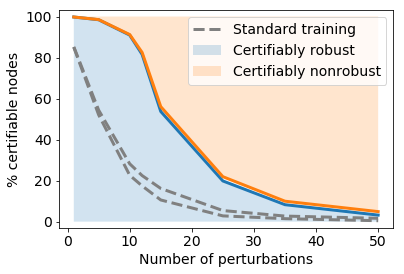

In [18]:
plt.plot(Q_range, 100*robust_normal.mean(1), linewidth=3, color="grey", linestyle="--", label="Standard training")
plt.plot(Q_range, 100*(1-nonrobust_normal.mean(1)), linewidth=3, color="grey", linestyle="--")

plt.plot(Q_range, 100*(robust.mean(1)), linewidth=3)
plt.fill_between(Q_range, 0, 100*robust.mean(1), alpha=0.2, label="Certifiably robust")
plt.plot(Q_range, 100*(1-nonrobust.mean(1)), linewidth=3)
plt.fill_between(Q_range, 100, 100*(1-nonrobust.mean(1)), where=nonrobust.mean() <= 1,
                alpha=0.2, label="Certifiably nonrobust")
plt.xlabel("Number of perturbations", fontsize=14)
plt.ylabel("% certifiable nodes", fontsize=14)

ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=14)
plt.ylim((-3,103))
plt.legend(fontsize=14)
plt.show()